# Fitting a line to data using MCMC

In this example we will be going over Exercise 6 from [Hogg 2010](http://arxiv.org/abs/1008.4686).  We will be fitting a line to data using a model that rejects outliers using an MCMC sampler.

## Packages being used
+ `numpy`: doing math on arrays
+ `numpyro`: this does the heavy lifting for the MCMC code
+ `matplotlib`: plot our results
+ `graphviz`: plotting numpyro models as graphs
+ `pandas`: read in data table

## Relevant documentation
+ introduction to probabilistic programming: https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Prologue/Prologue.ipynb
+ `matplotlib`: https://matplotlib.org/stable/api/pyplot_summary.html
+ how to pick priors: https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations
+ introduction to numpyro for astronomers: https://dfm.io/posts/intro-to-numpyro/

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import numpyro.infer as infer
import arviz
import pandas
import mpl_style

%matplotlib inline
plt.style.use(mpl_style.style1)

# Tell numpyro to use each CPU core as a different "device"
numpyro.set_host_device_count(4)

### Read in the data
First lets read in the data we will be fitting:

In [2]:
data = pandas.read_csv('data.csv')

x_mean = data.x.mean()
x_std = data.x.std()
y_mean = data.y.mean()
y_std = data.y.std()

# center and scale data
x_center = jnp.array((data.x - x_mean) / x_std)
y_center = jnp.array((data.y - y_mean) / y_std)
sy_center = jnp.array(data.sy / y_std)
sx_center = jnp.array(data.sx / x_std)

# data order
idx = data.x.argsort()


def un_center(b0_prime, b1_prime, x_mean, x_std, y_mean, y_std):
    b0 = (b0_prime * y_std) - (b1_prime * x_mean * y_std/x_std) + y_mean
    x = x_mean - (x_std / b1_prime) * ((y_mean / y_std) + b0_prime)
    b1 = -b0 / x
    return b0, b1

### What does centering the data do?
We will be fitting a line to our data with a slope and an intercept.  In the original data space these two value are highly correlated, a small change in slope will result in a large change in the intercept and vice-versa.  By centering and scaling the data we are ensuring the intercept is close to 0 and the `x` and `y` values are about the same size.  This reduces the correlation between the two fit parameters (e.g. you can adjust the slope and keep the intercept the same).

### Plot the data
Lets take a look at our data to see what we are fitting:

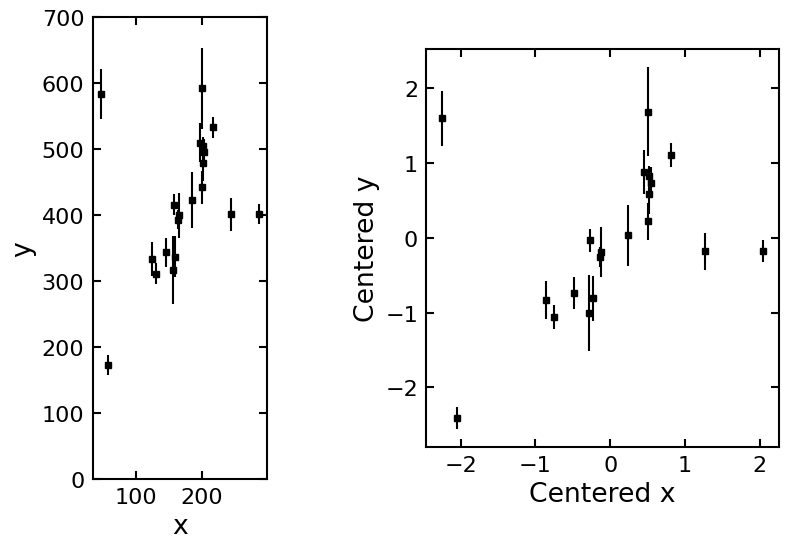

In [3]:
errorbar_kwargs = {
    'ls': 'None',
    'mfc': 'k',
    'mec': 'k',
    'ms': 5,
    'marker': 's',
    'ecolor': 'k'
}

plt.figure(1, figsize=(10, 6))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax1.errorbar(data.x, data.y, data.sy, **errorbar_kwargs)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_ylim(0, 700)
ax1.set_aspect(1)

ax2 = plt.subplot2grid((1, 2), (0, 1))
ax2.errorbar(x_center, y_center, sy_center, **errorbar_kwargs)
ax2.set_xlabel('Centered x')
ax2.set_ylabel('Centered y')
ax2.set_aspect(1);

## Bayesian modeling
The goal of this notebook will be to model the data using a Bayesian framework.  In short we want to find what is the probability of our model parameters given the observed data, from Bayes Rule we can write this down as:

$$P(\vec{\theta} | {y_i}) \propto P({y_i} | \vec{\theta}) P(\vec{\theta})$$

Typically the first term on the left-hand side is called the likelihood and is taken to be a normal distribution centered on the model and with a width equal to the observed uncertainties of each data point.

$$\mathscr{L} = \prod_i N(M(\vec{\theta}), {\sigma_i})|_{y_i}$$

The second term on the left-hand side is called the prior.  This encodes any prior information we have about each of the model parameters (typically this is where much of the physics of the problem lives).

To make the construction of these Bayesian models easier we will be using a Probabilistic Programming Language (PPL), specifically the Python based Numpyro.  We will specify the prior distribution for each of the model parameters, treat those distributions as variables in the code (as if they were regular numbers) to calculate the model, and identify any of these distributions that have observed data associated with them (typically just the likelihood term).

Once a model is defined, an Markov Chian Monte-Carlo (MCMC) algorithm can be used to generate samples that follow our target distribution (called the posterior distribution).  With Numpyro we will be making use of the No-U-Turn-Sampler (NUTS), a Hamiltonian Monte-Carlo (HMC) sampler that can converge quickly to both low- and high-dimension models.  This efficiency comes from HMC making use of the posterior's gradient information.

## OLS Model
As a starting point we will first build a least squares linear regression model and see how that does.  To help the sampler out a bit we will use the angle of the line and the perpendicular offset instead of slope and y-intercept.

### Numpyro syntax

#### `sample` vs `deterministic` variables
In Numpyro a `sample` is any value that will be fit to the data.  During the fitting process these parameters will be the ones the MC sampler will draw.  The `deterministic` values are any parameters that are calculated using the `sample` values and that you want to **record** its value at each step of the MC sampler.  These can be calculated after the the fit is finished, but for convenience we can set these values to be saved.

For this model we will convert the angle and perpendicular offset back into a slope and y-intercept using `deterministic`.  We will also un-center the slope, y-intercept, and best fit line back into its original coordinate system.

#### `plate`'s for vectors
In Numpyro a `plate` is just a vector quantity were each component is treated as being an **independent** sample or observation.

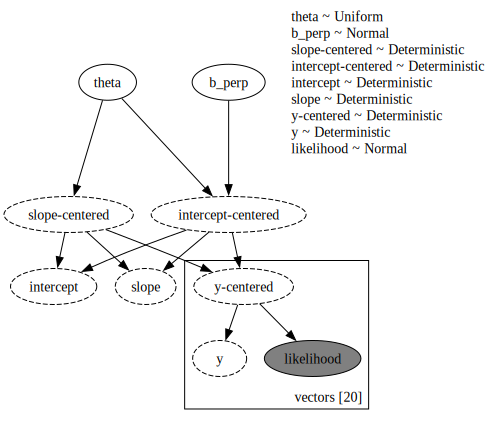

In [4]:
def mdl_ols():
    theta = numpyro.sample('theta', dist.Uniform(-0.5 * jnp.pi, 0.5 * jnp.pi))
    b_perp = numpyro.sample('b_perp', dist.Normal(0.0, 10.0))

    # convert to centered slope and intercept
    b1 = numpyro.deterministic('slope-centered', jnp.tan(theta))
    b0 = numpyro.deterministic('intercept-centered', b_perp / jnp.cos(theta))

    # un-center slope and intercept as Deterministic variables so we can plot them later
    b0_orig, b1_orig = un_center(b0, b1, x_mean, x_std, y_mean, y_std)
    numpyro.deterministic('intercept', b0_orig)
    numpyro.deterministic('slope', b1_orig)

    with numpyro.plate(f'vectors [{len(y_center)}]', len(y_center)):
        y_est_centered = numpyro.deterministic('y-centered', b0 + b1 * x_center)
        # un-center y_est for plotting later on
        numpyro.deterministic('y', (y_est_centered * y_std) + y_mean)

        # Likelihood
        numpyro.sample('likelihood', dist.Normal(y_est_centered, sy_center), obs=y_center)

numpyro.render_model(mdl_ols, render_distributions=True)

We can see the likelihood of the fit given the data is defined as a Normal distribution with scatter defined by observed y-errors.  The prior chosen for the angle is uniform from -90 to 90 and the perpendicular offset uses a weakly informative Normal prior.

### Numpyro's `render_model`
The above figure shows how each of the terms or our model feed into each other.  Solid non-filled ovals are the free parameters of the model, dashed non-filled ovals are any deterministic values that are calculated, solid filled ovals are the observed quantities, and each plate (e.g. vector quantity of a given length) have boxes drawn around them.

### Run HMC
Now we can run the HMC sampler to find the posterior distribution.

Numpyro makes use of [Jax](https://github.com/jax-ml/jax) under the hood, and as a result the random number generator's seed value needs to be handled using Jax directly (see [this page](https://jax.readthedocs.io/en/latest/key-concepts.html#key-concepts-prngs) for more details).

In [5]:
# Set a random seed
rng_key = jax.random.PRNGKey(0)

In [6]:
# Rotate the random seed
rng_key, rng_key_ = jax.random.split(rng_key)

kernel = infer.NUTS(mdl_ols)
mcmc = infer.MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4)
mcmc.run(rng_key_)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

### Check for convergence
Lets look at the results and see if HMC converged:

In [7]:
traces_ols = arviz.from_numpyro(mcmc)

print(f'divergences: {traces_ols.sample_stats.diverging.values.sum()}')
arviz.summary(
    traces_ols,
    var_names=['intercept', 'slope']
)

divergences: 0


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  214.518  14.197  187.863  241.586      0.253    0.179    3157.0   
slope        1.071   0.077    0.929    1.219      0.001    0.001    3042.0   

           ess_tail  r_hat  
intercept    2341.0    1.0  
slope        2357.0    1.0

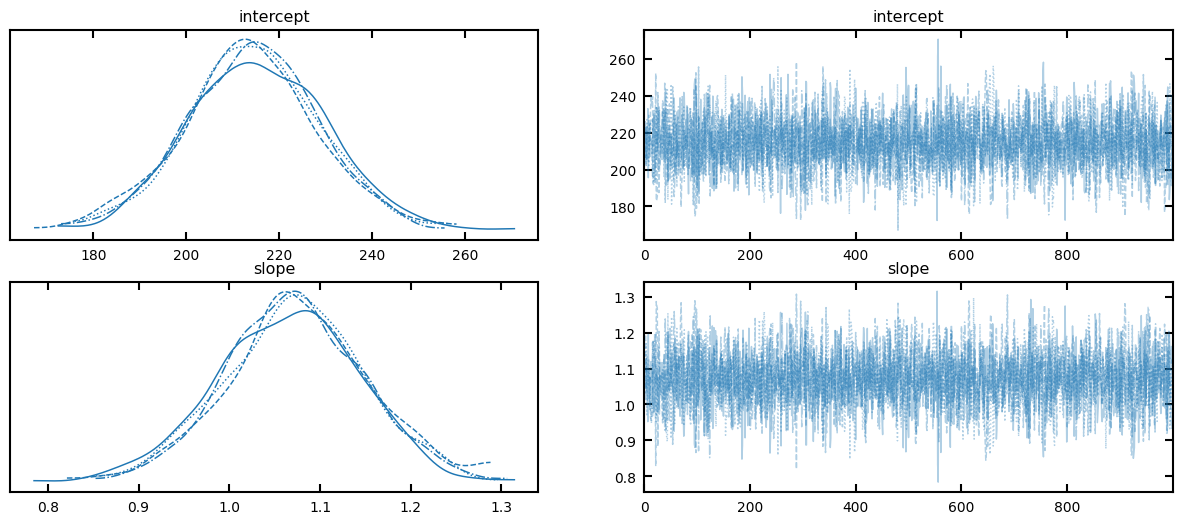

In [8]:
arviz.plot_trace(
    traces_ols,
    figsize=(15, 6),
    var_names=['intercept', 'slope']
);

Everything looks good, the `Rhat` values are all close to 1, and the traces have all mixed well.  Since we named the `y_est` variable with `deterministic` in the model it is also tracked at every sampling step.  This makes plotting the results easier since we don't need to evaluate the model for every `slope` and `intercept` value in the sample.

## Note about convergence
- `divergences` in a chain: these are places where the numerical integrator used inside HMC has failed because it's step-size was too big, setting the `target_accept_prob` in the `NUTS` class closer to `1` can sometimes help.  Strictly speaking, if any of your samples are `divergent` you can't fully "trust" any of them.
- `Rhat` (as measured by Arviz): This is a measure of the inter-chan variance of the sampler where each chain is run independently starting at different values.  It can be though of as "how many unique distributions do all the samples form."  If this is larger than about `1.06` your chains did not converge on the same solution.

While both of these diagnostics can tell you if you did not converge, they **can't** tell you if you did converge.

## Plot the results
Lets take a look at the covariance between the fitted intercept and slope.

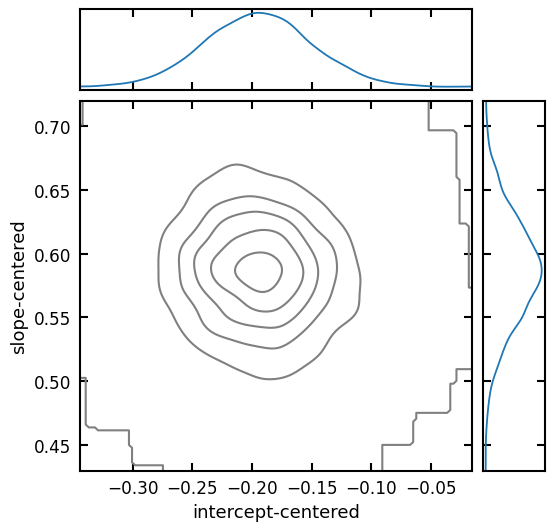

In [19]:
ax = arviz.plot_pair(
    traces_ols,
    var_names=['intercept-centered', 'slope-centered'],
    marginals=True,
    kind='kde',
    figsize=[6, 6],
    kde_kwargs={'contourf_kwargs': {'alpha': 0}}
)

Notice how in the centered parameter space these two values are not correlated (as expected), let transform the fit back to the original data space.

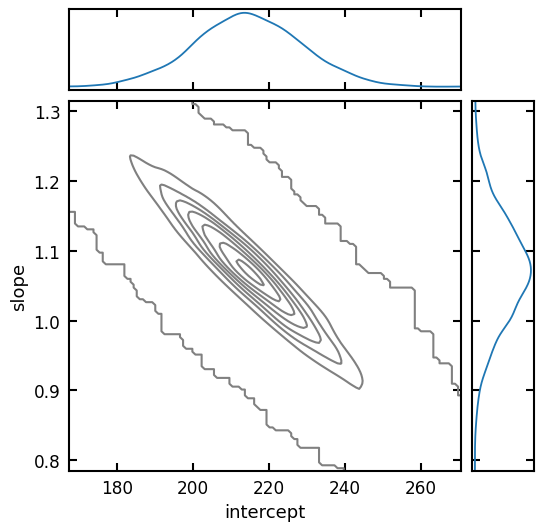

In [20]:
ax = arviz.plot_pair(
    traces_ols,
    var_names=['intercept', 'slope'],
    marginals=True,
    kind='kde',
    figsize=[6, 6],
    kde_kwargs={'contourf_kwargs': {'alpha': 0}}
)

Now we can see a large correlation in the fit parameters.  If we tried to run the HMC sampler in this data space it could have issues.

### Plotting the best fit
Finally we can plot the best fit on the original data.

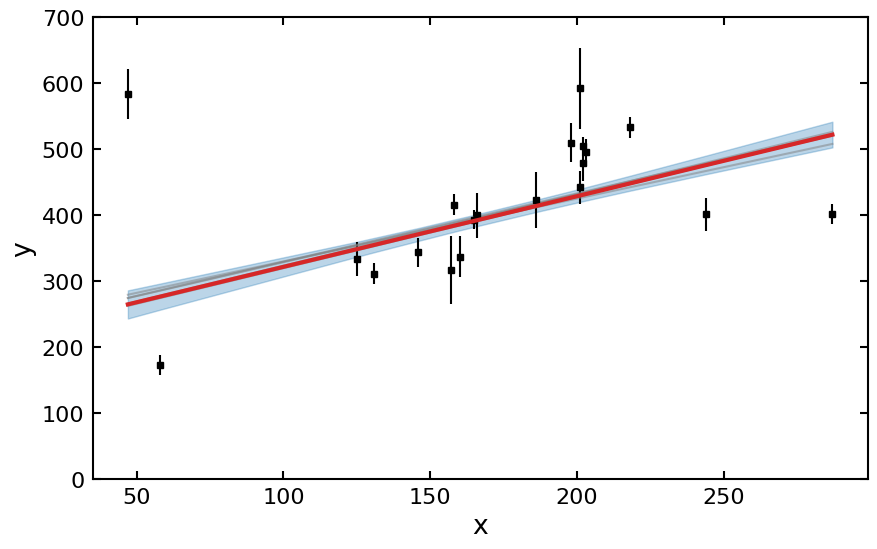

In [21]:
fill_kwargs = {
    'color': 'C0',
    'alpha': 0.3,
    'zorder': 1
}

# grab un-centered y-values from the sampler
y_est = traces_ols.posterior.y.data.reshape(-1, 20)

# plot original data
plt.figure(2, figsize=(10, 6))
plt.errorbar(data.x, data.y, data.sy, **errorbar_kwargs)

# find 2-sigma and median of best fit lines
y_est_minus_2_sigma, y_est_median, y_est_plus_2_sigma = np.percentile(
    y_est[:, idx],
    [2.5, 50, 97.5],
    axis=0
)

# plot the median of all best fit lines
plt.plot(data.x[idx], y_est_median, color='C3', lw=3, zorder=3)

# plot 2-sigma best fit region
plt.fill_between(data.x[idx], y_est_minus_2_sigma, y_est_plus_2_sigma, **fill_kwargs)

# plot a selection of best fit lines
plt.plot(data.x[idx], y_est[::800].T[idx], alpha=0.5, color='C7')

plt.xlabel('x')
plt.ylabel('y')
plt.ylim(0, 700);

From this plot we can see that the fitted line is being biased by several outliers in the data. Lets build a model that will filter out these outliers.

## Mixture model

The likelihood we need for this fit is shown in equation 13 of [Hogg 2010](http://arxiv.org/abs/1008.4686):

$$\mathscr{L(y_{i})} \propto \prod_{i=1}^{N}{\left[\frac{1}{\sqrt{2 \pi \sigma_{yi}^{2}}} \exp{\left(-\frac{[y_{i} - m x_{i} - b]^2}{2 \sigma_{yi}^{2}}\right)}\right]^{[1-q_{i}]} \times \left[\frac{1}{\sqrt{2 \pi [V_{b}+\sigma_{yi}^{2}]}} \exp{\left( -\frac{[y_{i} - Y_{b}]^2}{2[V_{b}+\sigma_{yi}^{2}]} \right)} \right]^{q_{i}}}$$

$$\{q_{i}\} \sim \text{Bernoulli}(P_b) $$

where $x_{i}, y_{i}, \sigma_{yi}$ are the data from the `.csv` file, $m, b$ are the slope and intercept of the line we are fitting, $q_{i}$ is $1$ if a point is an outlier and $0$ otherwise.  The set of these flags follow a Bernoulli distribution with a probability of being an outlier of $P_b$.  $Y_{b}, V_{b}$ are the parameters of the distribution the outliers are draw from.

## Marginalize over the individual $q_{i}$ values
To use this directly we would need to have the $q_{i}$'s to be discrete values (either `0` or `1`), but the HMC sampler we are using only works for continuous values.  To get around this we can marginalize over the individual $q_{i}$ values (i.e. do the integration by hand) and get a likelihood that only uses continuous variables.  See section 3 of Hogg's paper for a full derivation.

$$\mathscr{L(y_{i})} \propto \prod_{i=1}^{N}{\left[\frac{1-P_{b}}{\sqrt{2 \pi \sigma_{yi}^{2}}} \exp{\left(-\frac{[y_{i} - m x_{i} - b]^2}{2 \sigma_{yi}^{2}}\right)} + \frac{P_{b}}{\sqrt{2 \pi [V_{b}+\sigma_{yi}^{2}]}} \exp{\left( -\frac{[y_{i} - Y_{b}]^2}{2[V_{b}+\sigma_{yi}^{2}]} \right)} \right]}$$

Since we will be using a Bayesian approach to this fitting, we need to define priors for our fit parameters $\vec{\theta} = \left[ m, b, P_b, Y_b, V_b \right]$.  We will use weakly informative priors in all the parameters.

### Finding the $q_{i}$ values from the continuous case
The $q_{i}$ values can be calculated from the value of the continuous likelihood above:

$$q_{i} = \frac{\mathscr{L(y_{i})}}{\sum_i{\mathscr{L(y_{i})}}}$$

We will add this value as a `deterministic` quantity at the end of the model so we don't loose any information about the individual data points.

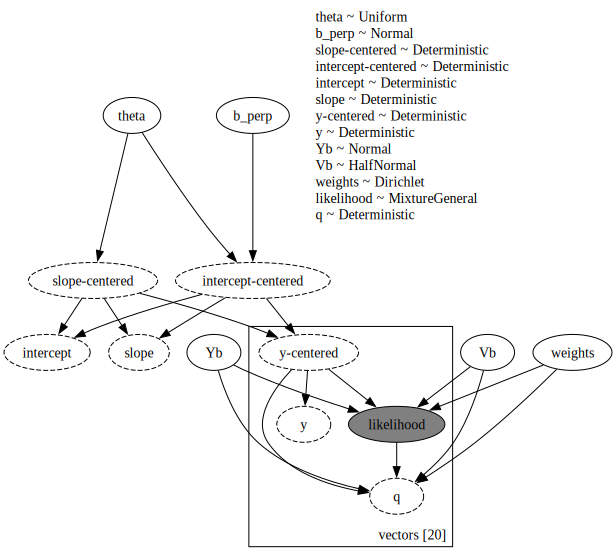

In [22]:
def mdl_signoise():
    theta = numpyro.sample('theta', dist.Uniform(-0.5 * jnp.pi, 0.5 * jnp.pi))
    b_perp = numpyro.sample('b_perp', dist.Normal(0.0, 10.0))
    b1 = numpyro.deterministic('slope-centered', jnp.tan(theta))
    b0 = numpyro.deterministic('intercept-centered', b_perp / jnp.cos(theta))

    # un-center slope and intercept as Deterministic variables so we can plot them later
    b0_orig, b1_orig = un_center(b0, b1, x_mean, x_std, y_mean, y_std)
    numpyro.deterministic('intercept', b0_orig)
    numpyro.deterministic('slope', b1_orig)

    with numpyro.plate(f'vectors [{len(y_center)}]', len(y_center)):
        y_est_centered = numpyro.deterministic('y-centered', b0 + b1 * x_center)
        # un-center y_est for plotting later on
        numpyro.deterministic('y', (y_est_centered * y_std) + y_mean)

    # foreground distribution
    fg_dist = dist.Normal(y_est_centered, sy_center)

    # Define weakly informative priors for the mean and variance of the outliers
    Yb = numpyro.sample('Yb', dist.Normal(0, 10))
    Vb = numpyro.sample('Vb', dist.HalfNormal(3))

    # background distribution
    bg_dist = dist.Normal(Yb, jnp.sqrt(Vb + sy_center**2))

    weights = numpyro.sample('weights', dist.Dirichlet(jnp.array([0.5, 0.5])))
    
    mix_categories = dist.Categorical(probs=weights)
    mixture = dist.Mixture(mix_categories, [bg_dist, fg_dist])
    with numpyro.plate(f'vectors [{len(y_center)}]', len(y_center)):
        y_ = numpyro.sample('likelihood', mixture, obs=y_center)

        log_probs = mixture.component_log_probs(y_)
        numpyro.deterministic(
            'q', jnp.exp(log_probs - jax.nn.logsumexp(log_probs, axis=-1, keepdims=True))
        )


numpyro.render_model(mdl_signoise, render_distributions=True)

In [23]:
# Rotate the random seed
rng_key, rng_key_ = jax.random.split(rng_key)

kernel = infer.NUTS(mdl_signoise, init_strategy=infer.init_to_median(), target_accept_prob=0.99)
mcmc = infer.MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4)
mcmc.run(rng_key_)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

If you see any divergent chains it typically means one or more of your priors are not set to reasonable distributions, some of your parameters have high covariance and should be rescaled, or you need to increase `target_accept_prob` from its default of 0.8 to 0.99 avoid divergent chains.

### Note about priors
Often times the priors you use will effect how fast the sampler will run.  If you are getting a small number of it/s try changing all your priors to `Normal` distributions to see if it runs any faster (`Uniform` priors can be very slow if they cover a large range).

See https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations for other tips about picking priors.

### Check for convergence

divergences: 0


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept-centered  0.032  0.059  -0.082    0.140      0.001    0.001   
slope-centered      1.237  0.063   1.118    1.352      0.001    0.001   
Vb                  1.647  1.264   0.117    4.009      0.018    0.012   
Yb                  0.277  0.674  -0.984    1.595      0.010    0.009   
weights[0]          0.261  0.123   0.050    0.485      0.001    0.001   
weights[1]          0.739  0.123   0.515    0.950      0.001    0.001   

                    ess_bulk  ess_tail  r_hat  
intercept-centered    7646.0    5311.0    1.0  
slope-centered        7516.0    5326.0    1.0  
Vb                    4869.0    4456.0    1.0  
Yb                    4740.0    3779.0    1.0  
weights[0]            7532.0    5041.0    1.0  
weights[1]            7532.0    5041.0    1.0

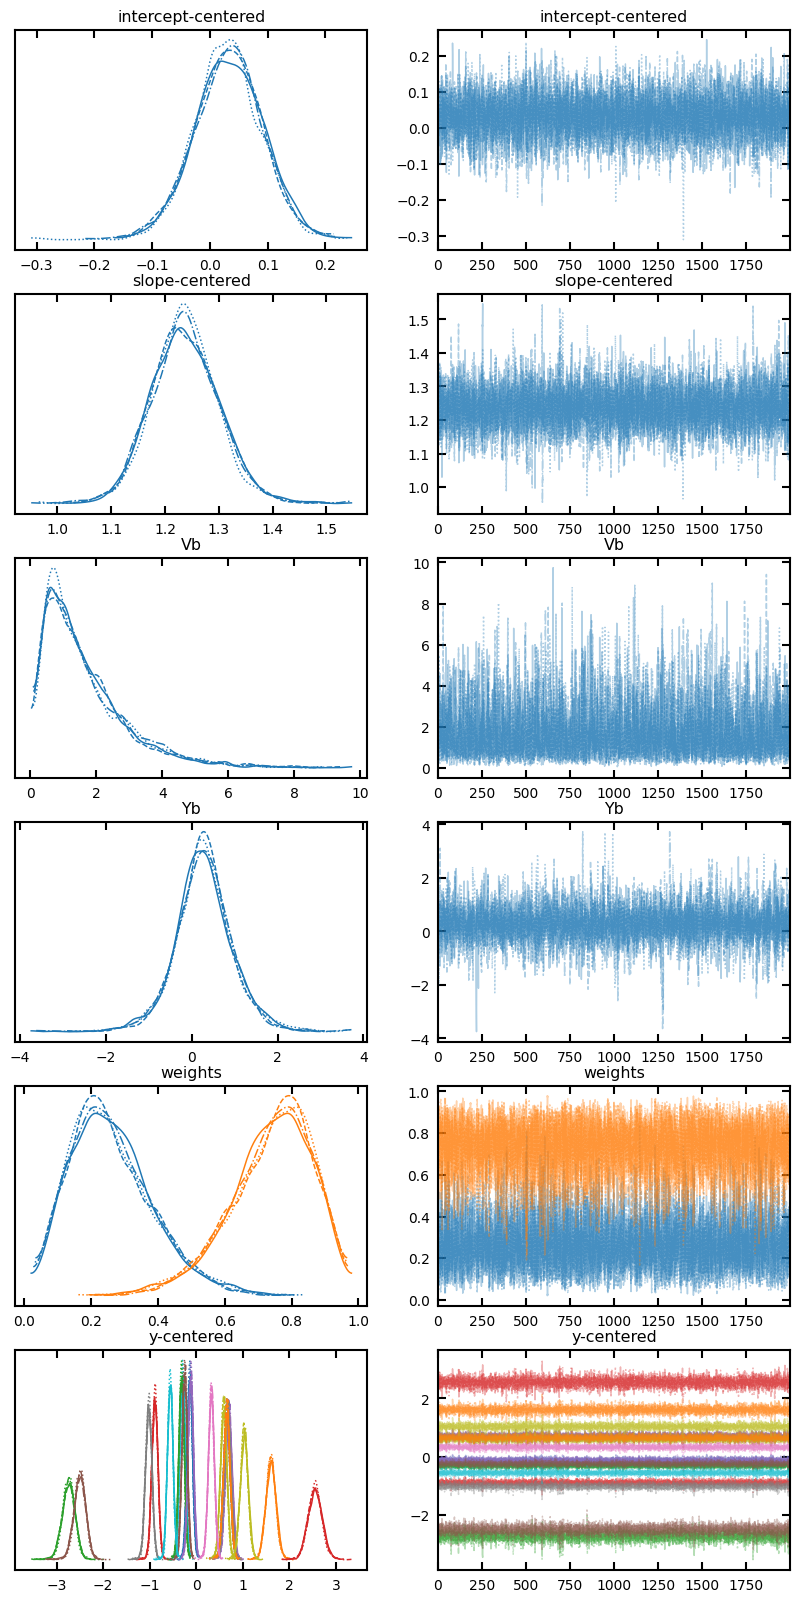

In [24]:
traces_signoise = arviz.from_numpyro(mcmc)

print(f'divergences: {traces_signoise.sample_stats.diverging.values.sum()}')

display(arviz.summary(
    traces_signoise,
    var_names=[
        'intercept-centered',
        'slope-centered',
        'Vb',
        'Yb',
        'weights'
    ]
))
arviz.plot_trace(
    traces_signoise,
    var_names=[
        'intercept-centered',
        'slope-centered',
        'Vb',
        'Yb',
        'weights',
        'y-centered'
    ],
    figsize=(10, 20)
);

As before we can see the `Rhat` values are all close to 1 and all the chains are well mixed.

Lets take a look at a corner plot of these fit variables after converting the slope and intercept back into the original data space.

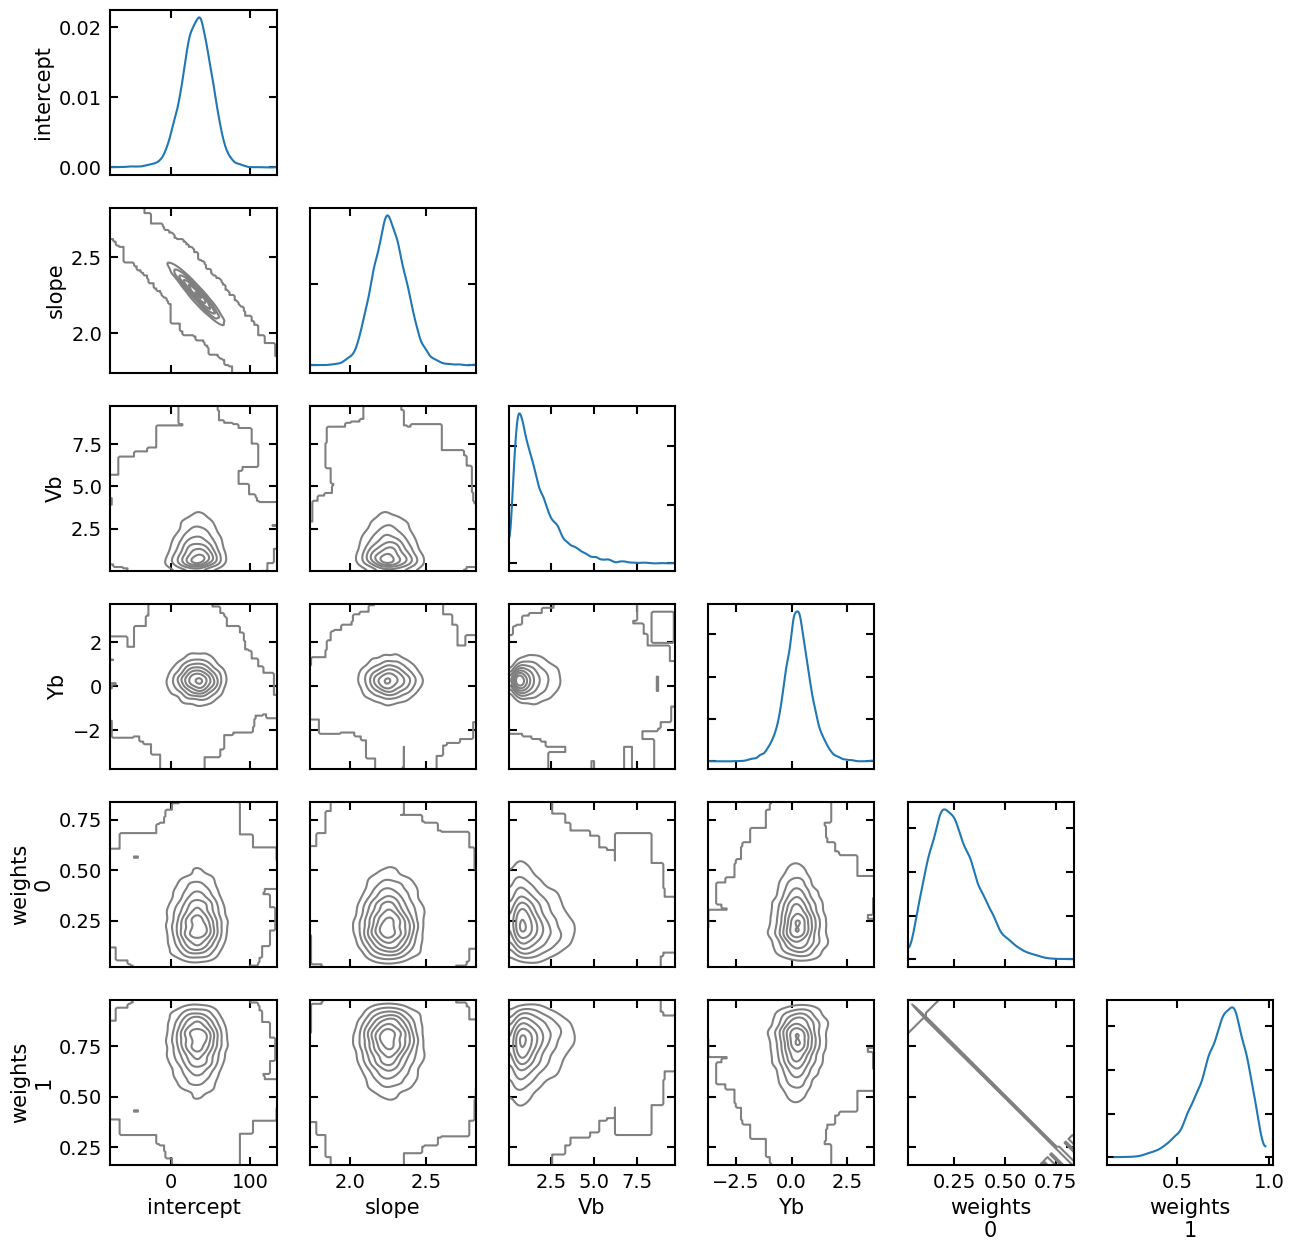

In [26]:
ax = arviz.plot_pair(
    traces_signoise,
    var_names=['intercept', 'slope', 'Vb', 'Yb', 'weights'],
    marginals=True,
    kind='kde',
    figsize=[15, 15],
    kde_kwargs={'contourf_kwargs': {'alpha': 0}}
)

As before we see a strong correlation between the slope and intercept.

### Finding the outliers
Unlike the OLS fit, this fit also has information about the probability of each point being an outlier ($q_i$).  Averaging these across each step and chin gives us the probability of each point being an outlier.

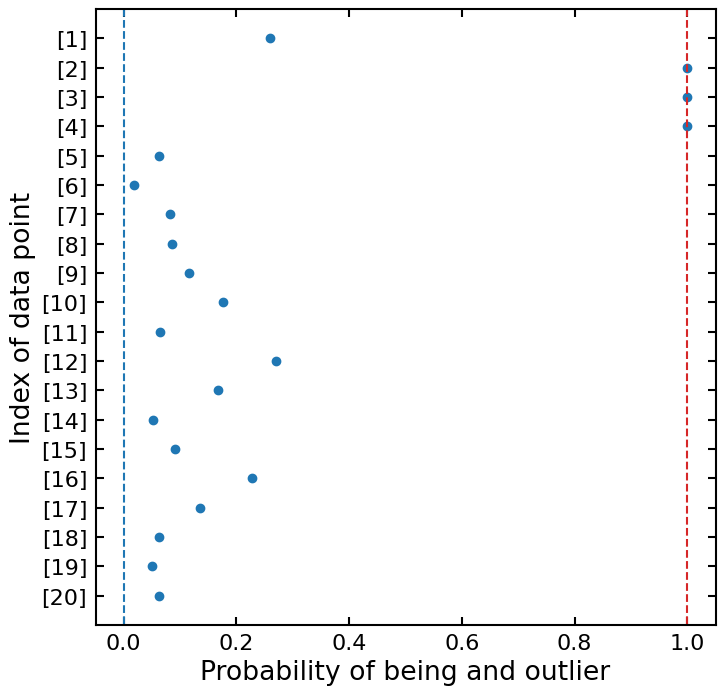

In [27]:
plt.figure(3, figsize=(8, 8))
avg_q = traces_signoise.posterior.q.mean(dim=['chain', 'draw'])[:, 0].data

plt.plot(avg_q, range(20), 'o')
plt.vlines([0, 1], -1, 20, ['C0', 'C3'], '--')
ax=plt.gca()
ax.set_yticks(range(20))
ax.set_yticklabels(['[{0}]'.format(i) for i in data.ID])
plt.xlabel('Probability of being and outlier')
plt.ylabel('Index of data point')
plt.ylim(20, -1);

From this plot we can see that three points are clearly marked as being outliers 100% of the time.  All of the other points are classed as outliers less that 33% of the time.

Lets take a closer look at the posterior distribution for the fraction of data points belonging to the outlier distribution ($weights$).  Looking at the above plot we might expect this to peak at $3/20 = 0.15$. 

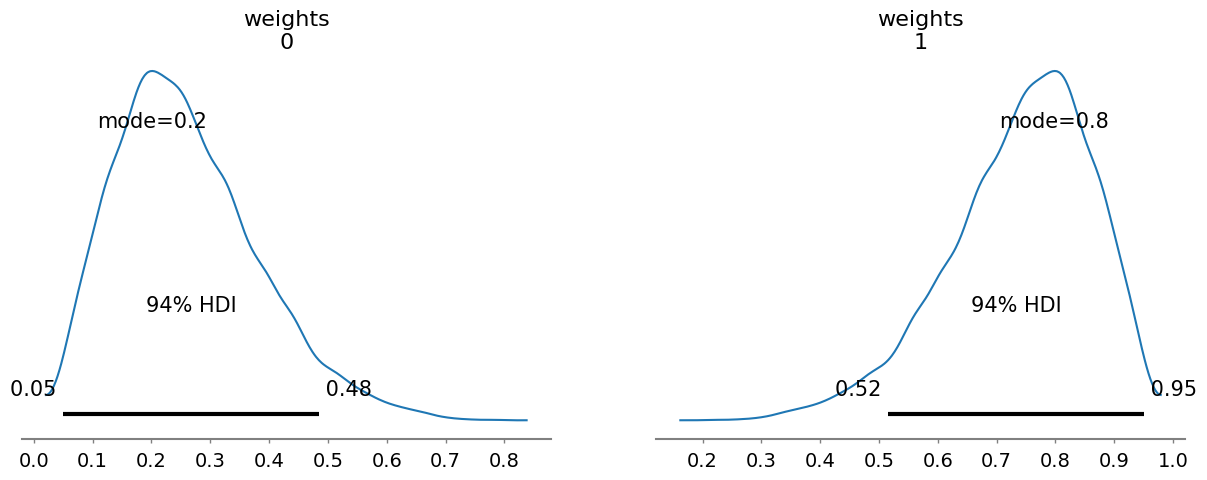

In [28]:
arviz.plot_posterior(
    traces_signoise,
    var_names=['weights'],
    figsize=(15, 5),
    point_estimate='mode'
);

Interestingly it peaks at 0.2, so we would expect 4 to 5 outliers instead of 3, so where does this number come from?

In [41]:
avg_q.mean()

0.24167088

That is closer to the peak of the posterior.  This is taking the sum of the outlier fraction for *all* points into account.  So overall there are "5" outliers but 2 of those are split among 17 data points.

### Plotting the fits
As before lets plot these fits on the original data points but this time we will highlight the outliers.

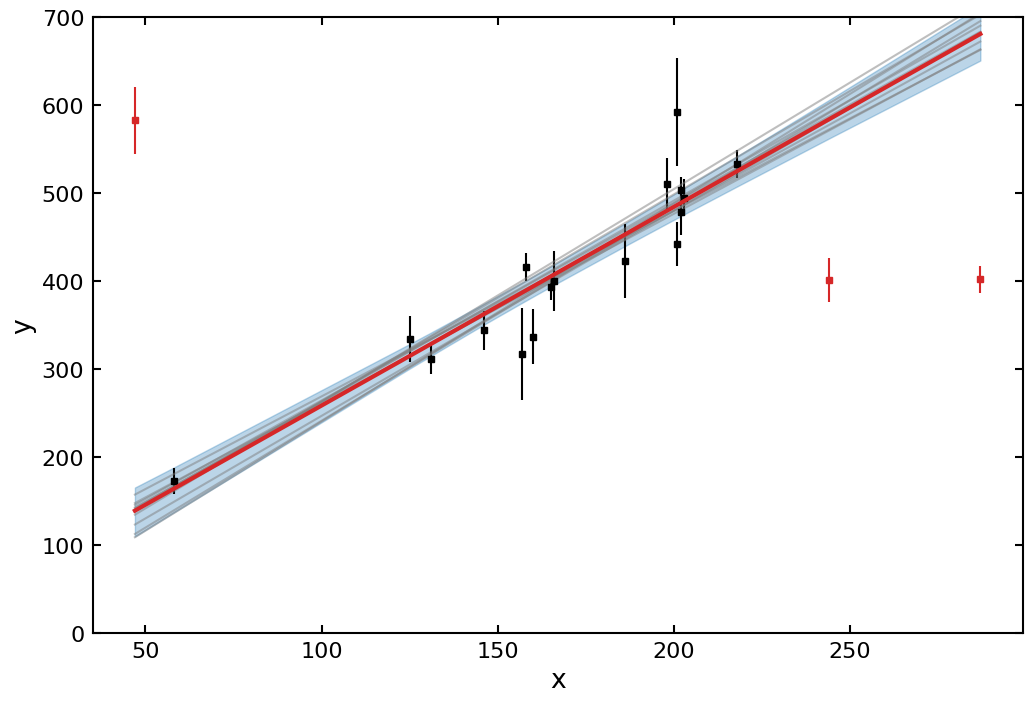

In [30]:
y_est = traces_signoise.posterior.y.data.reshape(-1, 20)

# find the outliers
outliers = avg_q > 0.8

plt.figure(4, figsize=(12, 8))
# plot inliers
plt.errorbar(data.x[~outliers], data.y[~outliers], data.sy[~outliers], **errorbar_kwargs)

# plot outliers
plt.errorbar(
    data.x[outliers],
    data.y[outliers],
    data.sy[outliers],
    ls='None',
    mfc='C3',
    mec='C3',
    ms=5,
    marker='s',
    ecolor='C3'
)

y_est_minus_2_sigma, y_est_median, y_est_plus_2_sigma = np.percentile(
    y_est[:, idx],
    [2.5, 50, 97.5],
    axis=0
)

# plot the mean of all best fit lines
plt.plot(data.x[idx], y_est_median, color='C3', lw=3, zorder=3)

# plot 2-sigma best fit region
plt.fill_between(data.x[idx], y_est_minus_2_sigma, y_est_plus_2_sigma, **fill_kwargs)

# plot a selection of best fit lines
plt.plot(data.x[idx], y_est[::800].T[idx], alpha=0.5, color='C7')

plt.xlabel('x')
plt.ylabel('y')
plt.ylim(0, 700);

Looking much better!  Our best fit line goes through all the data points without being confused by the outliers.

## How to deal with errors in the $x$ direction

Up until now we have only taken into account the errorbars in the $y$ direction. If you also wanted to account for the errors in the $x$ direction (assuming there are no covariances) the OLS model would look like this:

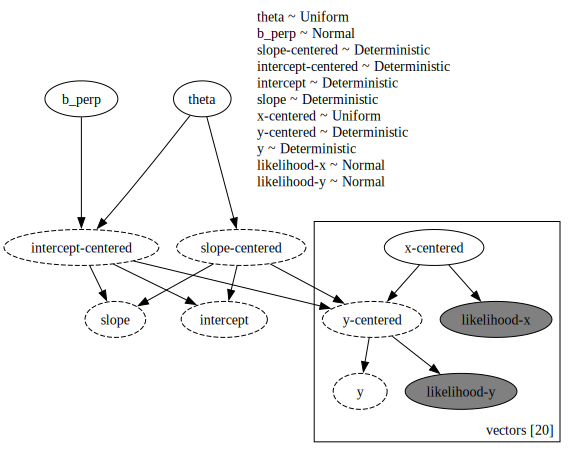

In [ ]:
def mdl_ols_sx():
    # Define weakly informative Normal priors (Ridge regression)
    theta = numpyro.sample('theta', dist.Uniform(-0.5 * jnp.pi, 0.5 * jnp.pi))
    b_perp = numpyro.sample('b_perp', dist.Normal(0.0, 10.0))
    b1 = numpyro.deterministic("slope-centered", jnp.tan(theta))
    b0 = numpyro.deterministic("intercept-centered", b_perp / jnp.cos(theta))

    # un-center slope and intercept as Deterministic variables so we can plot them later
    b0_orig, b1_orig = un_center(b0, b1, x_mean, x_std, y_mean, y_std)
    numpyro.deterministic('intercept', b0_orig)
    numpyro.deterministic('slope', b1_orig)

    with numpyro.plate(f'vectors [{len(y_center)}]', len(x_center)):
        # prior for each (centered) x data point taken to be uniform
        x_est_centered = numpyro.sample('x-centered', dist.Uniform(-5, 5))
        y_est_centered = numpyro.deterministic('y-centered', b0 + b1 * x_est_centered)
        # un-center y_est for plotting later on
        numpyro.deterministic('y', (y_est_centered * y_std) + y_mean)

        # Likelihood
        numpyro.sample('likelihood-x', dist.Normal(x_est_centered, sx_center), obs=x_center)
        numpyro.sample('likelihood-y', dist.Normal(y_est_centered, sy_center), obs=y_center)

numpyro.render_model(mdl_ols_sx, render_distributions=True)

This looks much like the model before, except this time we assume a `Uniform` prior on the $x$ positions and add in a second likelihood using the observed $x$ data.

In [32]:
# Rotate the random seed
rng_key, rng_key_ = jax.random.split(rng_key)

kernel = infer.NUTS(mdl_ols_sx, init_strategy=infer.init_to_median(), target_accept_prob=0.95)
mcmc = infer.MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4)
mcmc.run(rng_key_)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

divergences: 0


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept-centered -0.164  0.051  -0.262   -0.071      0.001    0.001   
slope-centered      0.703  0.053   0.607    0.802      0.001    0.001   

                    ess_bulk  ess_tail  r_hat  
intercept-centered    5019.0    3150.0    1.0  
slope-centered        4171.0    3355.0    1.0

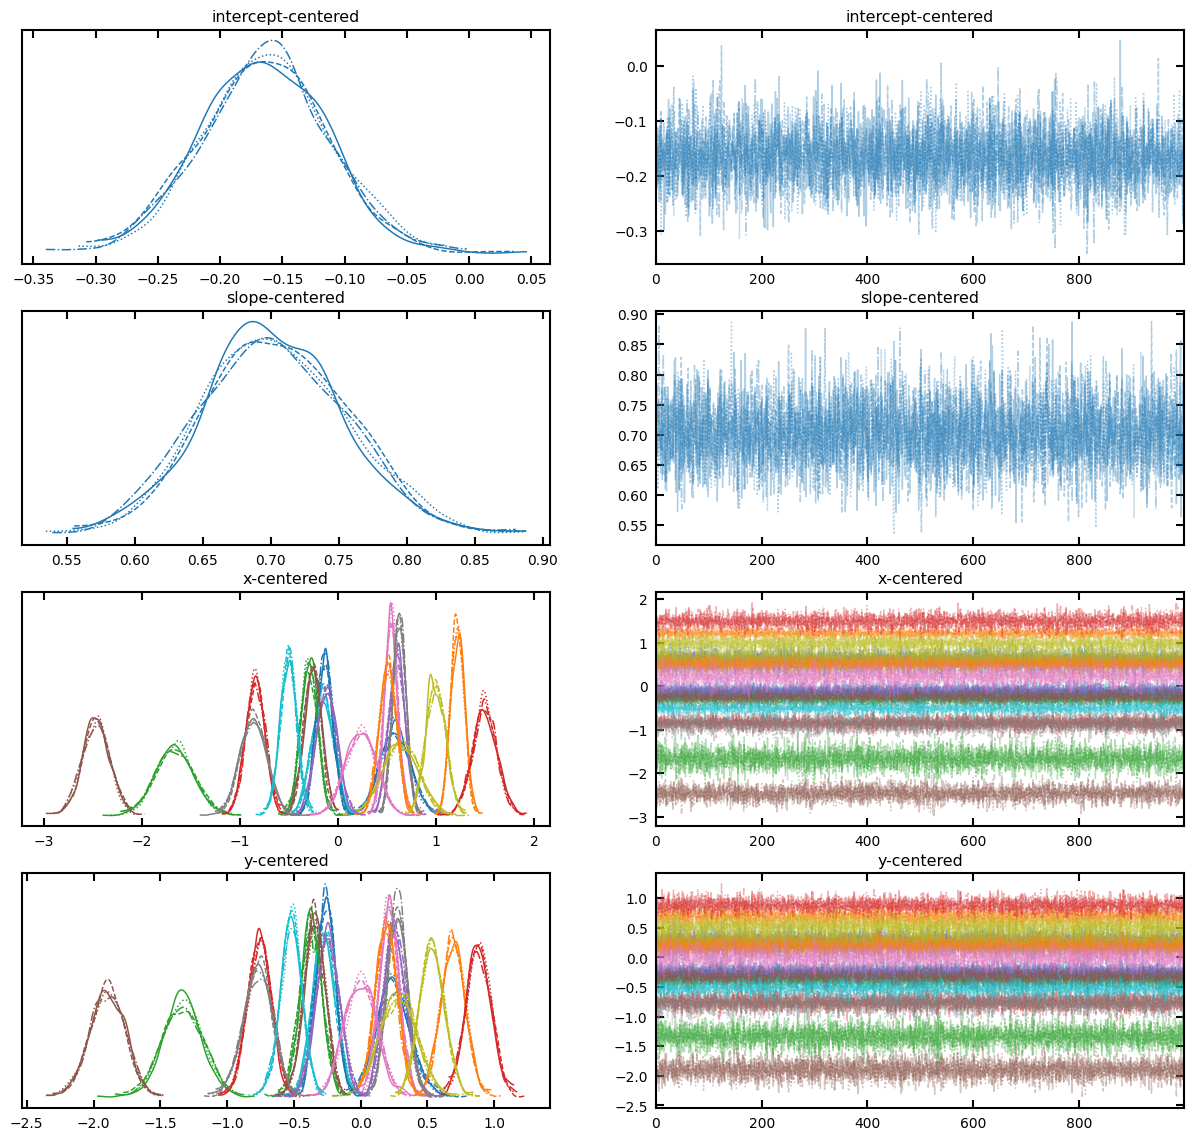

In [33]:
traces_ols_2 = arviz.from_numpyro(mcmc)

print(f'divergences: {traces_ols_2.sample_stats.diverging.values.sum()}')

display(arviz.summary(
    traces_ols_2,
    var_names=[
        'intercept-centered',
        'slope-centered'
    ]
))
arviz.plot_trace(
    traces_ols_2,
    var_names=[
        'intercept-centered',
        'slope-centered',
        'x-centered',
        'y-centered'
    ],
    figsize=(15, 14)
);

Care should be taken when plotting these results as each $y_{est}$ has been calculated using slightly different $x_{est}$ values, so they can't be averaged as nicely as before.

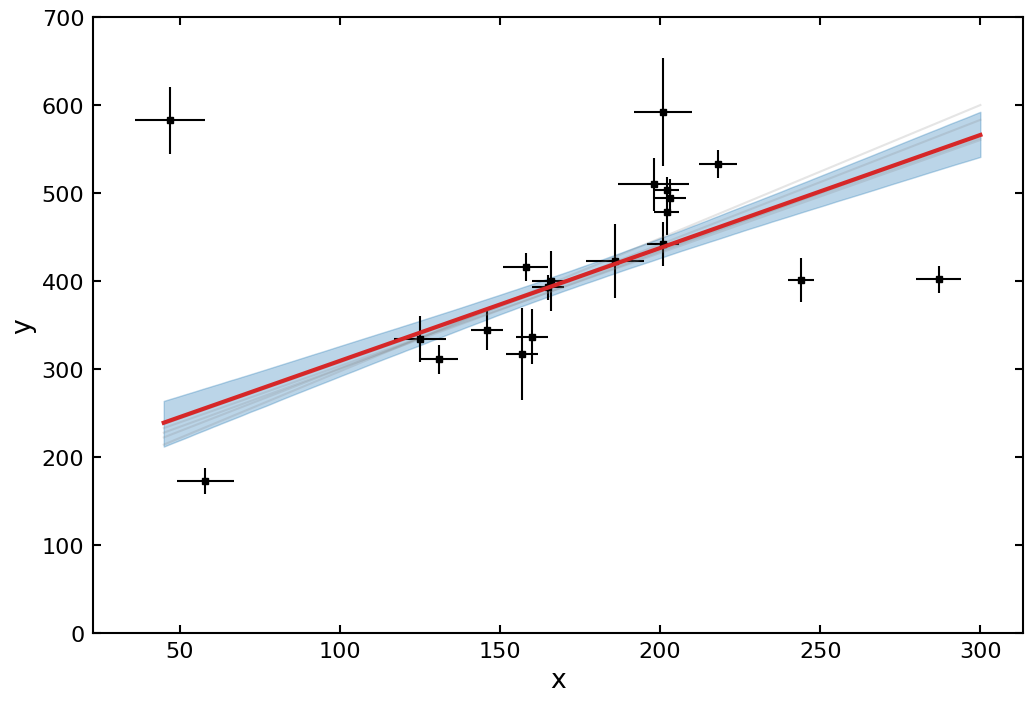

In [34]:
# get y_est evaluated at all the same x positions
x_eval = np.linspace(45, 300, 200)
y_eval = traces_ols_2.posterior.slope.data.reshape(-1, 1) * x_eval + traces_ols_2.posterior.intercept.data.reshape(-1, 1)

# get 2-sigma region and median
y_est_minus_2_sigma, y_est_median, y_est_plus_2_sigma = np.percentile(
    y_eval,
    [2.5, 50, 97.5],
    axis=0
)

plt.figure(5, figsize=(12, 8))
plt.errorbar(data.x, data.y, data.sy, data.sx, **errorbar_kwargs)

# plot the mean of all best fit lines
plt.plot(x_eval, y_est_median, color='C3', lw=3, zorder=3)

# plot 2-sigma best fit region
plt.fill_between(x_eval, y_est_minus_2_sigma, y_est_plus_2_sigma, **fill_kwargs)

# plot a selection of best fit lines
plt.plot(x_eval, y_eval[::800].T, alpha=0.2, color='C7')

plt.xlabel('x')
plt.ylabel('y')
plt.ylim(0, 700);

A similar setup can be used as in the mixture model above to account for outliers.

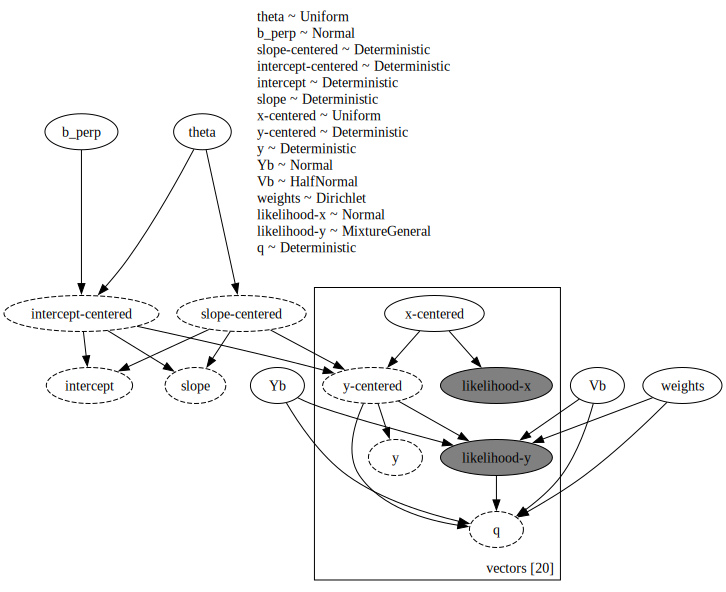

In [35]:
def mdl_all():
    # Define weakly informative Normal priors (Ridge regression)
    theta = numpyro.sample('theta', dist.Uniform(-0.5 * jnp.pi, 0.5 * jnp.pi))
    b_perp = numpyro.sample('b_perp', dist.Normal(0.0, 10.0))
    b1 = numpyro.deterministic("slope-centered", jnp.tan(theta))
    b0 = numpyro.deterministic("intercept-centered", b_perp / jnp.cos(theta))

    # un-center slope and intercept as Deterministic variables so we can plot them later
    b0_orig, b1_orig = un_center(b0, b1, x_mean, x_std, y_mean, y_std)
    numpyro.deterministic('intercept', b0_orig)
    numpyro.deterministic('slope', b1_orig)

    with numpyro.plate(f'vectors [{len(y_center)}]', len(x_center)):
        x_est_centered = numpyro.sample('x-centered', dist.Uniform(-5, 5))
        y_est_centered = numpyro.deterministic('y-centered', b0 + b1 * x_est_centered)
        # un-center y_est for plotting later on
        numpyro.deterministic('y', (y_est_centered * y_std) + y_mean)
    
    # foreground distribution
    fg_dist = dist.Normal(y_est_centered, sy_center)
    
    # Define weakly informative priors for the mean and variance of the outliers
    Yb = numpyro.sample('Yb', dist.Normal(0, 10))
    Vb = numpyro.sample('Vb', dist.HalfNormal(3))

    # background distribution
    bg_dist = dist.Normal(Yb, jnp.sqrt(Vb + sy_center**2))

    weights = numpyro.sample('weights', dist.Dirichlet(jnp.array([0.5, 0.5])))
    
    mix_categories = dist.Categorical(probs=weights)
    mixture = dist.Mixture(mix_categories, [bg_dist, fg_dist])

    with numpyro.plate(f'vectors [{len(y_center)}]', len(x_center)):
        # Likelihood
        numpyro.sample('likelihood-x', dist.Normal(x_est_centered, sx_center), obs=x_center)
        y_ = numpyro.sample('likelihood-y', mixture, obs=y_center)
        
        log_probs = mixture.component_log_probs(y_)
        numpyro.deterministic(
            'q', jnp.exp(log_probs - jax.nn.logsumexp(log_probs, axis=-1, keepdims=True))
        )

numpyro.render_model(mdl_all, render_distributions=True)

In [36]:
# Rotate the random seed
rng_key, rng_key_ = jax.random.split(rng_key)

kernel = infer.NUTS(mdl_all, init_strategy=infer.init_to_median(), target_accept_prob=0.99)
mcmc = infer.MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4)
mcmc.run(rng_key_)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

divergences: 0


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept-centered  0.009  0.070  -0.119    0.140      0.001    0.001   
slope-centered      1.250  0.094   1.080    1.429      0.001    0.001   
Vb                  1.685  1.331   0.091    4.183      0.015    0.012   
Yb                  0.303  0.682  -0.983    1.653      0.008    0.008   
weights[0]          0.254  0.119   0.054    0.476      0.001    0.001   
weights[1]          0.746  0.119   0.524    0.946      0.001    0.001   

                    ess_bulk  ess_tail  r_hat  
intercept-centered    8535.0    6229.0    1.0  
slope-centered        7638.0    5719.0    1.0  
Vb                    9299.0    5877.0    1.0  
Yb                    8201.0    4681.0    1.0  
weights[0]           11708.0    5245.0    1.0  
weights[1]           11708.0    5245.0    1.0

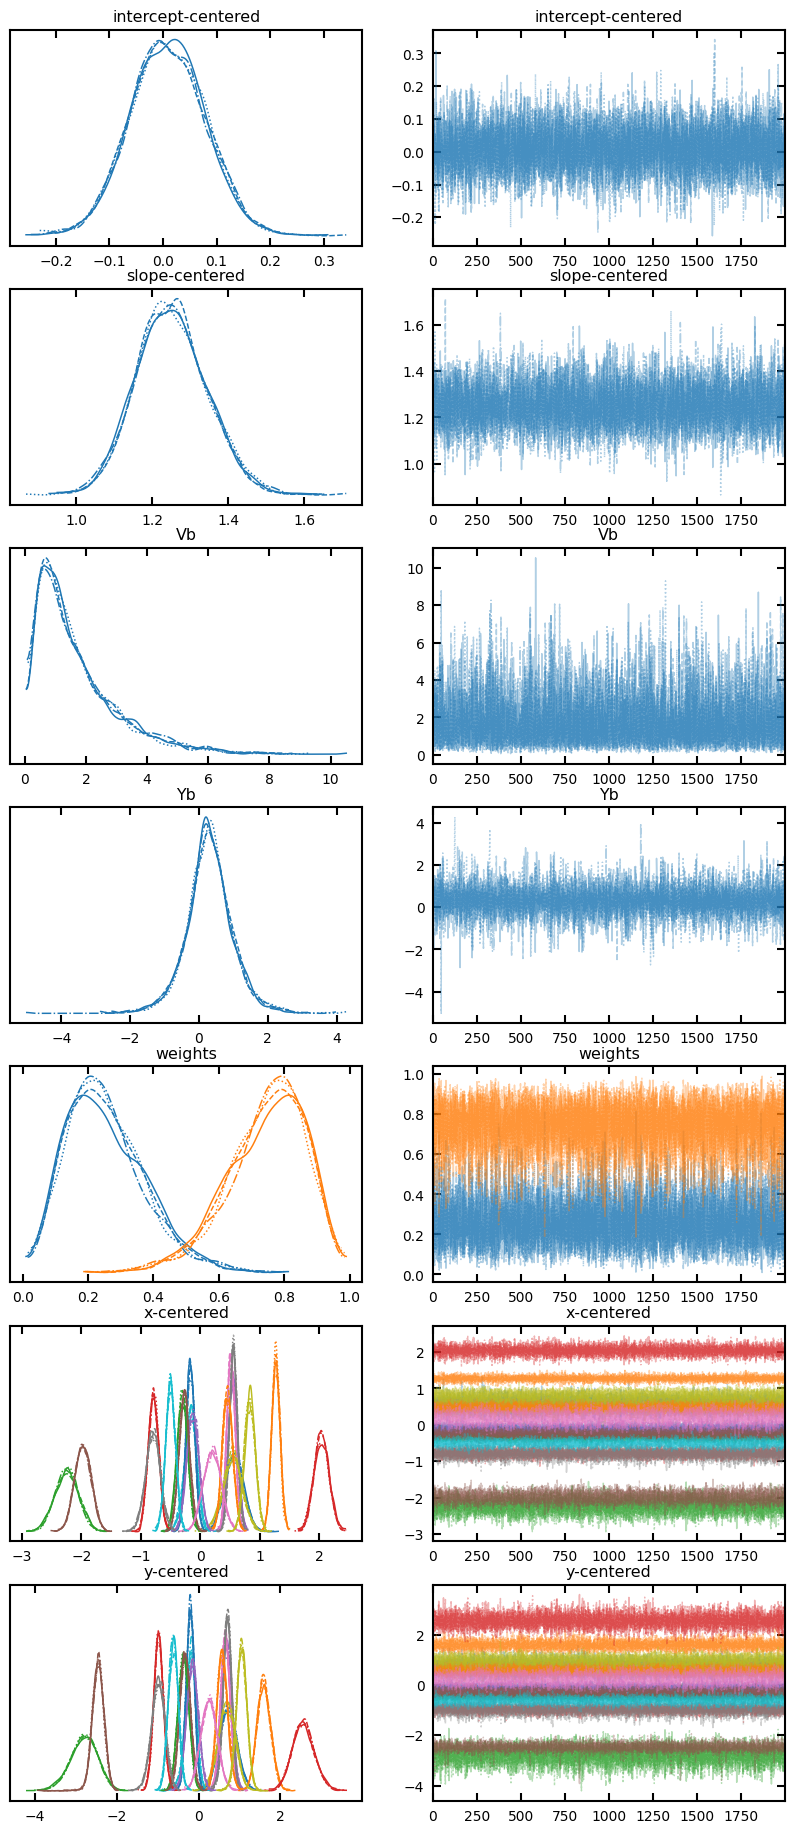

In [37]:
traces_all = arviz.from_numpyro(mcmc)

print(f'divergences: {traces_all.sample_stats.diverging.values.sum()}')

display(arviz.summary(
    traces_all,
    var_names=[
        'intercept-centered',
        'slope-centered',
        'Vb',
        'Yb',
        'weights'
    ]
))
arviz.plot_trace(
    traces_all,
    var_names=[
        'intercept-centered',
        'slope-centered',
        'Vb',
        'Yb',
        'weights',
        'x-centered',
        'y-centered'
    ],
    figsize=(10, 23)
);

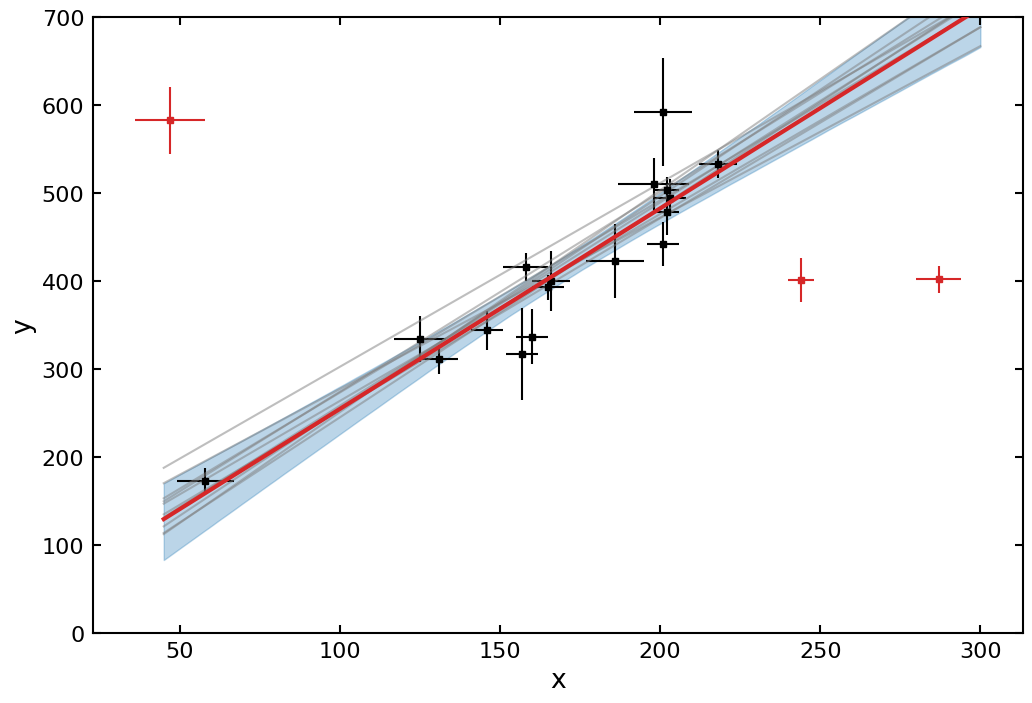

In [38]:
avg_q = traces_all.posterior.q.mean(dim=['chain', 'draw'])[:, 0].data

# evaluate all lines on the same x-values
x_eval = np.linspace(45, 300, 200)
y_eval = traces_all.posterior.slope.data.reshape(-1, 1) * x_eval + traces_all.posterior.intercept.data.reshape(-1, 1)

# find the outliers
outliers = avg_q > 0.8

plt.figure(4, figsize=(12, 8))
# plot inliers
plt.errorbar(data.x[~outliers], data.y[~outliers], data.sy[~outliers], data.sx[~outliers], **errorbar_kwargs)

# plot outliers
plt.errorbar(
    data.x[outliers],
    data.y[outliers],
    data.sy[outliers],
    data.sx[outliers],
    ls='None',
    mfc='C3',
    mec='C3',
    ms=5,
    marker='s',
    ecolor='C3'
)

y_est_minus_2_sigma, y_est_median, y_est_plus_2_sigma = np.percentile(
    y_eval,
    [2.5, 50, 97.5],
    axis=0
)

# plot the mean of all best fit lines
plt.plot(x_eval, y_est_median, color='C3', lw=3, zorder=3)

# plot 2-sigma best fit region
plt.fill_between(x_eval, y_est_minus_2_sigma, y_est_plus_2_sigma, **fill_kwargs)

# plot a selection of best fit lines
plt.plot(x_eval, y_eval[::800].T, alpha=0.5, color='C7')

plt.xlabel('x')
plt.ylabel('y')
plt.ylim(0, 700);